In [29]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import itertools
import random


class graph_sampler:
    '''
    
    This class provides four sampling techniques:
    1. simple_random_sampling
    2. simple_random_walk_sampling
    3. random_walk_flyback_sampling
    4. random_walk_induced_graph_sampling
    
    Note that when initializing a new instance of this class, sampler_type should be the name of the
    required technique as specified above, except for simple_random_walk_sampling where sampler_type
    must be a tuple ("random_walk_flyback_sampling", p_flyback)

    In case one wants to preprocess graphlets on-the-fly, a preprocessing function Adj->vector should be provided.
    
    After you initialize an instance, you can sample your Graph/list of Graphs by calling sample 
    method ( the last method)
    
    '''
    
    def __init__(self,sampler_type,nodes_num,preprocess=None):
        if preprocess is None:
            preprocess=lambda x:x.flatten()
        elif preprocess=="Eigen_values":
            preprocess=lambda x:np.sort( np.real( LA.eig(x)[0] ) ).flatten()       #########################################
        self.preprocess=preprocess
        self.nodes_num=nodes_num
        if(type(sampler_type)==tuple): # ex: this is the case of random_walk_flyback (name, p_flyback)
            self.sampler_type=sampler_type[0]
            if(sampler_type[0]=="random_walk_flyback_sampling"):self.p_flyback=sampler_type[1]
        else : self.sampler_type=sampler_type
    
    def simple_sampling(self,G,nodes_num):     # one simple_random_sample of G
        return G.subgraph(random.sample(G.nodes(), nodes_num))

    def random_walk_sampling_simple(self,complete_graph, nodes_to_sample):  # also just one sample using this method
        T,growth_size=100,2  # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            curr_node = chosen_node
            iteration = iteration+1

            if iteration % T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                edges_before_t_iter = sampled_graph.number_of_edges()
        return sampled_graph
    
    def random_walk_sampling_with_fly_back(self,complete_graph, nodes_to_sample, fly_back_prob): # returns one sample
        growth_size,T=2,100       # number of iterations (attempts to sample the graph)
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.nodes[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample

        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.nodes[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            choice = np.random.choice(['prev','neigh'], 1, p=[fly_back_prob,1-fly_back_prob])
            if choice == 'neigh':
                curr_node = chosen_node
            iteration=iteration+1

            if iteration % T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes-1)
                    print ("Choosing another random node to continue random walk ")
                edges_before_t_iter = sampled_graph.number_of_edges()

        return sampled_graph
    
    
    def random_walk_induced_graph_sampling(self, complete_graph, nodes_to_sample):
        growth_size,T=2,50       # number of iterations (attempts to sample the graph)##################################### 100->400
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.nodes[n]['id'] = n
            
        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes - 1)

        Sampled_nodes = set([complete_graph.nodes[index_of_first_random_node]['id']])

        iteration = 1
        nodes_before_t_iter = 0
        curr_node = index_of_first_random_node
        while len(Sampled_nodes) != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            if len(edges)>0:
                index_of_edge = random.randint(0, len(edges) - 1)
                chosen_node = edges[index_of_edge]
                Sampled_nodes.add(complete_graph.nodes[chosen_node]['id'])
                curr_node = chosen_node
            iteration=iteration+1

            if iteration % T == 0:
                if ((len(Sampled_nodes) - nodes_before_t_iter) < growth_size):
                    curr_node = random.randint(0, nr_nodes - 1)
                nodes_before_t_iter = len(Sampled_nodes)

        sampled_graph = complete_graph.subgraph(Sampled_nodes)

        return sampled_graph
    
    def sample(self,G, samples_num=1):
        for _ in range (samples_num):
            if self.sampler_type=="simple_random_sampling": sampled_subgraph=self.simple_sampling(G,self.nodes_num)
                
            elif self.sampler_type=="simple_random_walk_sampling":
                sampled_subgraph=self.random_walk_sampling_simple(G,self.nodes_num)

            elif self.sampler_type=="random_walk_flyback_sampling":
                sampled_subgraph=self.random_walk_sampling_with_fly_back(G,self.nodes_num,self.p_flyback)
                
            elif self.sampler_type=="random_walk_induced_graph_sampling":
                sampled_subgraph=self.random_walk_induced_graph_sampling(G,self.nodes_num)
          
            adjacency=self.preprocess(nx.to_numpy_array(sampled_subgraph))[:,None] if _==0                       else np.concatenate((adjacency,self.preprocess(nx.to_numpy_array(sampled_subgraph))[:,None]),axis=1)
        return adjacency


########################################################################################
# reading all graphlet of size n
n,sz_n=5,34
graphlets=nx.read_graph6('graph5.g6')

########################################################################################
# generating the graph
g=nx.read_adjlist("SBM1_adj")
########################################################################################
# calculating the frequency of each graphlet
sampler=graph_sampler(sampler_type="simple_random_sampling", nodes_num=5)
MAX_samples=2000
freq=np.zeros(sz_n)
for i in range(MAX_samples):
    subg = sampler.simple_sampling(g,n)
    for targ_ind,target in enumerate(graphlets):
        if nx.is_isomorphic(subg, target):
            freq[targ_ind]+=1
np.savetxt('Est_FrequencyGraphlet_size5_class1_UniformSampling.csv', freq, delimiter=',')
        
########################################################################################

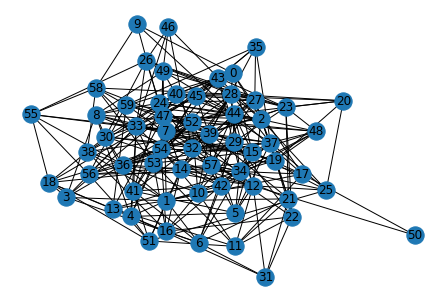

In [9]:
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import itertools
        



########################################################################################
# reading all graphlet of size n
n,sz_n=5,34
graphlets=nx.read_graph6('graph5.g6')

########################################################################################
# generating the graph
nodes_per_graph, block_size, fraction, mult_factor, avg_deg=60, 10, 0.3, 3, 10
blocks_num=int(nodes_per_graph/block_size)
sizes=[block_size]*blocks_num
p_in=fraction                                  # else fraction*mult_factor
p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
p=p_out*np.ones([blocks_num]*2)+(p_in-p_out)*np.eye(blocks_num)

g=nx.stochastic_block_model(sizes, p)
nx.draw(g,with_labels=True)
plt.show()
#nx.write_adjlist(g,"SBM0_adj")
########################################################################################
# calculating the frequency of each graphlet
freq=np.zeros(sz_n)
for sub_nodes in itertools.combinations(g.nodes(),n):
  subg = g.subgraph(sub_nodes)
  for targ_ind,target in enumerate(graphlets):
    if nx.is_isomorphic(subg, target):
      freq[targ_ind]+=1
np.savetxt('frequency_graphlet_of_size5_1.csv', freq, delimiter=',')
        
########################################################################################

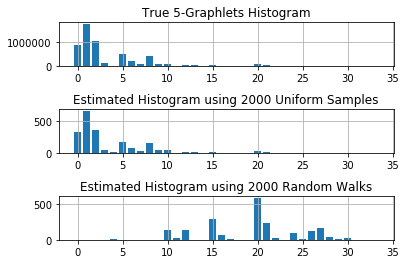

In [53]:
true_hist_0=np.loadtxt ('frequency_graphlet_of_size5_0.csv')
US_hist_0=np.loadtxt('Est_FrequencyGraphlet_size5_class0_UniformSampling.csv')
RW_hist_0=np.loadtxt('Est_FrequencyGraphlet_size5_class0_RandomWalk.csv')
t=range(0,34)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
plt.subplot(311)
plt.bar(t,  true_hist_0)
plt.title('True 5-Graphlets Histogram')
plt.grid()
plt.subplot(312)
plt.title('Estimated Histogram using 2000 Uniform Samples')
plt.grid()
plt.bar(t, US_hist_0)
plt.subplot(313)
plt.bar(t, RW_hist_0)
plt.grid()
plt.title('Estimated Histogram using 2000 Random Walks')
plt.savefig('class0_hist.jpg')

In [ ]:
true_hist_1=np.loadtxt ('frequency_graphlet_of_size5_1.csv')
US_hist_1=np.loadtxt('Est_FrequencyGraphlet_size5_class1_UniformSampling.csv')
RW_hist_1=np.loadtxt('Est_FrequencyGraphlet_size5_class1_RandomWalk.csv')
t=range(0,34)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)
plt.subplot(311)
plt.bar(t,  true_hist_1)
plt.title('True 5-Graphlets Histogram')
plt.grid()
plt.subplot(312)
plt.title('Estimated Histogram using 2000 Uniform Samples')
plt.grid()
plt.bar(t, US_hist_1)
plt.subplot(313)
plt.bar(t, RW_hist_1)
plt.grid()
plt.title('Estimated Histogram using 2000 Random Walks')
plt.savefig('class0_hist.jpg')